<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/AdaptiveMidpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [7]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

import sympy as sp


clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [0]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

# Working on the mesh

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


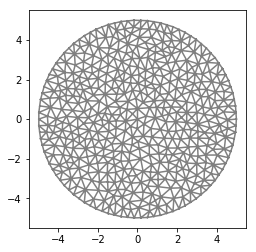

In [20]:
'''
geo_choice = 1
if geo_choice == 1:
    mesh_file = "fru_M_100383_1D.xml"
else:    
    mesh_file = "fru_M_100383_3D.xml"
mesh_file_exists = os.path.isfile(mesh_file)
if (mesh_file_exists==False):
    !wget https://github.com/van-dang/MRI-Cloud/raw/mesh/$mesh_file''.zip  
    !unzip -q $mesh_file''.zip
mymesh = Mesh(mesh_file);
'''

domain = Circle(Point(0,0), 5)
r = 15   # Resolution of mesh
mymesh = generate_mesh(domain, r)
plot(mymesh)


# Solve the Bloch-Torrey equation

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
t:   0.00  T: 53700.00 dt: 200.0 qvalue: 4.742741e-05 Completed 0.00%
t: 20000.00  T: 53700.00 dt: 200.0 qvalue: 4.742741e-05 Completed 37.11%
t: 40000.00  T: 53700.00 dt: 200.0 qvalue: 4.742741e-05 Completed 74.21%


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Successfully Completed! Elapsed time: 8.137170 seconds
b: 10000.000, g: 0.177, q: 4.743e-05, Signal: 4.394e+01, Normalized signal: 5.611e-01, dt: 200.000, hmin: 3.483e-01, whole_vol: 78.306, vol_of_interest: 78.306, Free signal: 9.358e-14, elasped time 8.137 (s)

save to log.txt


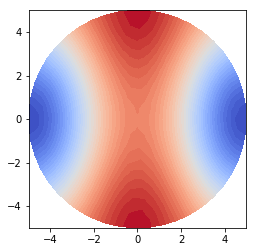

In [54]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [10000]
signal_array=[];
voi_array=[];
whole_vol_array = [];

def compute_est(theta, u_L, u_H):
    """Return error estimate by Richardson extrapolation"""
    p = 2 if theta == 0.5 else 1
    est = sqrt(assemble((u_L - u_H)**2*dx)) / (2**p - 1)
    return est

def compute_new_dt(theta, est, tol, dt):
    """Return new time step"""
    p = 2 if theta == 0.5 else 1
    rho = 0.9
    dt_new = dt * ( rho * tol / est )**(1/p)
    return dt_new

def ThetaMethodF1(ft, ift, mri_para, mri_simu, w, v, mydomain):
    if (mydomain.IsDomainMultiple==True):
      if (mydomain.IsDomainPeriodic==True) and sum(mydomain.PeriodicDir)>0:
          F = ThetaMethodF_sBC2c(ft, ift, mri_para, w, v, mri_simu, mydomain)
      else:
          F = ThetaMethodF_wBC2c(ft, ift, mri_para, w, v, mri_simu, mydomain)
    else:
      if (mydomain.IsDomainPeriodic==True) and sum(mydomain.PeriodicDir)>0:
          F = ThetaMethodF_sBC1c(ft, ift, mri_para, w, v, mri_simu, mydomain)
      else:
          F = ThetaMethodF_wBC1c(ft, ift, mri_para, w, v, mri_simu, mydomain)
    return F  

def mid_point_single_step(tp, t, dt, w0):
    ft_prev = mri_para.time_profile(tp);
    ift_prev = mri_para.itime_profile(tp);
    ft = mri_para.time_profile(t);
    ift = mri_para.itime_profile(t);
    A = 1/dt*M + assemble(ThetaMethodF1(ft, ift, mri_para, mri_simu, w, v, mydomain))
    b = 1/dt*M*w0.vector() - assemble(ThetaMethodF1(ft_prev, ift_prev, mri_para, mri_simu, w0, v, mydomain))
    w1 =  Function(mydomain.W);
    linsolver.solve(A, w1.vector(),b);
    return w1

  
for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.stype='PGSE'                                # sequence type
    mri_para.bvalue = bvalue;                              # bvalue
    mri_para.delta, mri_para.Delta = 10600, 43100        # time sequence
    mri_para.set_gradient_dir(mymesh, 1, 0, 0)           # gradient direction

    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 


    mri_para.Apply()
    mri_simu.k = 200;                                    # time-step size
    mri_simu.nskip = 100;                                  # frequency to print ouputs
    mydomain = MyDomain(mymesh, mri_para)
    mydomain.phase = None
    mydomain.PeriodicDir = [0, 0, 0];             # Direction of the periodicity
    mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
    ################################################################################
    mydomain.Apply()   # Call Apply before setting the diffusion tensor
    ################################################################################
    # Impose the diffusion coefficient
    mydomain.D0 = 3e-3
    mydomain.D = mydomain.D0;
    #################################################################################

    # linsolver = PETScLUSolver("mumps")
    linsolver = KrylovSolver("bicgstab")

    # mri_simu.solve(mydomain, mri_para, linsolver)

    mri_simu.Dirac_Delta, w0 = mri_simu.InitialCondition(mydomain, None)

    stepcounter = 0;

    M = MassMatrix(mydomain);

    mri_simu.t = 0;
    ft_prev  =  mri_para.time_profile(mri_simu.t);
    ift_prev = mri_para.itime_profile(mri_simu.t);

    v = TestFunction(mydomain.W); w = TrialFunction(mydomain.W);
        
    start_time = time.time()
  
    tp = mri_simu.t
    while mri_simu.t < mri_para.T + mri_simu.k: # Time-stepping loop
        if stepcounter % mri_simu.nskip == 0:
            print('t: %6.2f '%mri_simu.t, 'T: %6.2f'%mri_para.T, 'dt: %.1f'%mri_simu.k,'qvalue: %e'%mri_para.qvalue,'Completed %3.2f%%'%(float(mri_simu.t)/float(mri_para.T+mri_simu.k)*100.0));
        
        u_low  = mid_point_single_step(tp, mri_simu.t, mri_simu.k,   w0);
        u_mid  = mid_point_single_step(tp, mri_simu.t + mri_simu.k/2, mri_simu.k/2, w0);
        u_high = mid_point_single_step(tp + mri_simu.k/2, mri_simu.t + mri_simu.k, mri_simu.k/2, u_mid);
        
        theta = 0.5
        tol = 1e-2
        est = compute_est(theta, u_low, u_high)
        dt_new = compute_new_dt(theta, est, tol,  mri_simu.k)
        # dt_new = min(dt_new, T-t)

        w0.vector()[:] = u_high.vector()[:]
                
        tp = mri_simu.t
        mri_simu.t += mri_simu.k;
        stepcounter += 1;

    mri_simu.elapsed_time = time.time() - start_time
    print("Successfully Completed! Elapsed time: %f seconds"%mri_simu.elapsed_time)   
    
    # Post-processing
    one = Function(mydomain.V)
    one.vector()[:] = 1
    whole_vol = assemble(one*dx)
    voi = assemble(mri_simu.Dirac_Delta*dx)
    if mydomain.IsDomainMultiple == True:
        u0r_0, u0i_0, u1r_0, u1i_0 = split(w0)
        initial0 = assemble((1-mydomain.phase)*mri_simu.Dirac_Delta*dx);
        signal0 = assemble(((1-mydomain.phase)*u0r_0)*dx);
        initial1 = assemble(mydomain.phase*mri_simu.Dirac_Delta*dx)
        signal1 = assemble((mydomain.phase*u1r_0)*dx);
        signal = assemble((mydomain.phase*u1r_0+(1-mydomain.phase)*u0r_0)*dx);
        print('Signal on each compartment')
        print('Sum initial0: %.3e, Signal0: %.3e'%(initial0, signal0))
        print('Sum initial1: %.3e, Signal1: %.3e'%(initial1, signal1))
        out_text = 'b: %.3f, g: %.3f, q: %.3e, Signal: %.3e, Normalized signal: %.3e, kappa: %.3e, dt: %.3f, hmin: %.3f, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, mri_para.gvalue, mri_para.qvalue, signal, signal/voi, mydomain.kappa, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*mydomain.D0), mri_simu.elapsed_time)
        print(out_text)
        V0 = FunctionSpace(mydomain.mesh0, mydomain.Ve);
        V1 = FunctionSpace(mydomain.mesh1, mydomain.Ve);
        u0r_0p = project(u0r_0,V0)
        u1r_0p = project(u1r_0,V1)
        if mydomain.tdim==mydomain.gdim and not(plt==None):
            plt.figure(10000);
            plot(u0r_0p, cmap="coolwarm")
            plt.figure(10001);            
            plot(u1r_0p, cmap="coolwarm")  
        File("u0r.pvd")<<u0r_0p
        File("u1r.pvd")<<u1r_0p
    else:
        ur, ui = split(w0)
        signal = assemble(ur*dx);
        out_text = 'b: %.3f, g: %.3f, q: %.3e, Signal: %.3e, Normalized signal: %.3e, dt: %.3f, hmin: %.3e, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, mri_para.gvalue, mri_para.qvalue, signal, signal/voi, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*mydomain.D0), mri_simu.elapsed_time)
        print(out_text)
        V = FunctionSpace(mydomain.mymesh,mydomain.Ve);
        ur_p = project(ur,V)
        if mydomain.tdim==mydomain.gdim and not(plt==None): 
            plt.figure(10000);
            plot(ur_p, cmap="coolwarm")
        File("ur.pvd")<<ur_p
    signal_array.append(signal)
    voi_array.append(voi)
    whole_vol_array.append(whole_vol);
    
    comm = MPI.comm_world
    rank = comm.Get_rank()    
    
    print("save to log.txt")
    outfile = open('log.txt', 'a')
    if int(rank) == 0:
            outfile.write(out_text)
    outfile.close()  

In [0]:
import numpy as np
plt.plot(bvalues, np.divide(signal_array,signal_array[0]))
plt.xlabel('b (s/mm^2)')
plt.ylabel('S(b)/S(0)')